In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

## Create Example Data

In [2]:
increment = 0.001

x1 = np.arange(0, 1.001, increment)
y1 = x1 + np.random.normal(scale=0.05, size=x1.size)

x2 = np.arange(0, 1.001, increment)
y2 = x2**2 + np.random.normal(scale=0.05, size=x2.size)

x3 = np.arange(0, 1.001, increment)
y3 = np.sin(3.14*x3) + np.random.normal(scale=0.05, size=x3.size)
y3_test = np.sin(3.14*x3) + np.random.normal(scale=0.05, size=x3.size)

x4 = np.arange(0, 1.001, increment)
y4 = np.random.rand(x4.size)
y4_test = np.random.rand(x4.size)

In [3]:
y1.size

1001

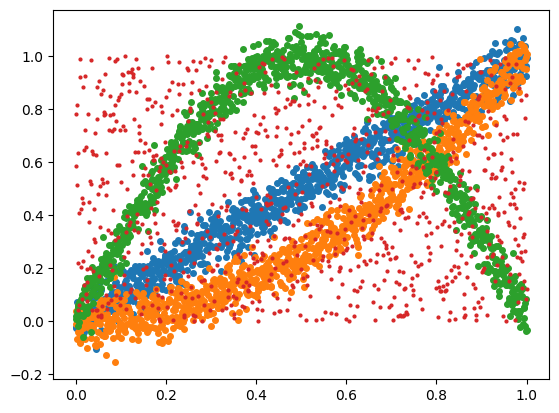

In [4]:
plt.plot(x1, y1, 'o', markersize=4)
plt.plot(x2, y2, 'o', markersize=4)
plt.plot(x3, y3, 'o', markersize=4)
plt.plot(x4, y4, 'o', markersize=2)

## Random Forest Illustration

### Some functions to get details of individual trees

In [5]:
def get_max_depth_vals(clf):
    max_depth_list = []
    num_nodes = []
    num_leaves = []
    for estimator in clf.estimators_:
        # print(estimator.get_depth(), estimator.tree_.max_depth)
        max_depth_list.append(estimator.get_depth())
        num_nodes.append(estimator.tree_.node_count)
        num_leaves.append(estimator.get_n_leaves())
    return max_depth_list, num_nodes, num_leaves

In [6]:
def print_entire_tree(clf, tree_num=0):
    n_nodes = clf.estimators_[tree_num].tree_.node_count
    children_left = clf.estimators_[tree_num].tree_.children_left
    children_right = clf.estimators_[tree_num].tree_.children_right
    feature = clf.estimators_[tree_num].tree_.feature
    threshold = clf.estimators_[tree_num].tree_.threshold
    values = clf.estimators_[tree_num].tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print(
        "The binary tree structure has {n} nodes and has "
        "the following tree structure:\n".format(n=n_nodes)
    )
    for i in range(n_nodes):
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node with value={value}.".format(
                    space=node_depth[i] * "\t", node=i, value=values[i]
                )
            )
        else:
            print(
                "{space}node={node} is a split node with value={value}: "
                "go to node {left} if X[:, {feature}] <= {threshold} "
                "else to node {right}.".format(
                    space=node_depth[i] * "\t",
                    node=i,
                    left=children_left[i],
                    feature=feature[i],
                    threshold=threshold[i],
                    right=children_right[i],
                    value=values[i],
                )
            )

In [7]:
def get_decision_path(clf, X_test, tree_num=0, sample_id=0):
    feature = clf.estimators_[tree_num].tree_.feature
    threshold = clf.estimators_[tree_num].tree_.threshold
    node_indicator = clf.estimators_[tree_num].decision_path(X_test)
    leaf_id = clf.estimators_[tree_num].apply(X_test)
    
    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]

    print("Rules used to predict sample {id}:\n".format(id=sample_id))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue

        # check if value of the split feature for sample 0 is below threshold
        if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=feature[node_id],
                value=X_test[sample_id, feature[node_id]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )

The above two code cells is borrowed from: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html.

### Training some example RF models

In [8]:
# Default Parameters
X_tmp = x3.reshape(-1, 1)
rf_reg_def = RandomForestRegressor(n_estimators=50)
rf_reg_def.fit(X_tmp, y3)
y3_pred_default = rf_reg_def.predict(X_tmp)

x3_def_train_score = rf_reg_def.score(X_tmp, y3)
x3_def_test_score = rf_reg_def.score(X_tmp, y3_test)
print(f'Train: {x3_def_train_score:.3f} | Test: {x3_def_test_score:.3f}')

max_depth_list, num_nodes, num_leaves = get_max_depth_vals(rf_reg_def)
print(min(max_depth_list), max(max_depth_list))
print(min(num_nodes), max(num_nodes))
print(min(num_leaves), max(num_leaves))
print()

# ---

# Set min_samples_leaf
rf_reg = RandomForestRegressor(n_estimators=50, min_samples_leaf=0.03)
rf_reg.fit(X_tmp, y3)
y3_pred_minsamplf = rf_reg.predict(X_tmp)

x3_set_train_score = rf_reg.score(X_tmp, y3)
x3_set_test_score = rf_reg.score(X_tmp, y3_test)
print(f'Train: {x3_set_train_score:.3f} | Test: {x3_set_test_score:.3f}')

max_depth_list, num_nodes, num_leaves = get_max_depth_vals(rf_reg)
print(min(max_depth_list), max(max_depth_list))
print(min(num_nodes), max(num_nodes))
print(min(num_leaves), max(num_leaves))
print()

Train: 0.994 | Test: 0.966
21 30
1229 1311
615 656

Train: 0.970 | Test: 0.966
8 10
25 33
13 17



### Visualizing a single tree in the forest

In [21]:
print_entire_tree(rf_reg, tree_num=0)

The binary tree structure has 31 nodes and has the following tree structure:

node=0 is a split node with value=[[0.62806058]]: go to node 1 if X[:, 0] <= 0.14549999684095383 else to node 4.
	node=1 is a split node with value=[[0.22689682]]: go to node 2 if X[:, 0] <= 0.08000000193715096 else to node 3.
		node=2 is a leaf node with value=[[0.11775717]].
		node=3 is a leaf node with value=[[0.35630526]].
	node=4 is a split node with value=[[0.70044036]]: go to node 5 if X[:, 0] <= 0.8135000169277191 else to node 26.
		node=5 is a split node with value=[[0.82381755]]: go to node 6 if X[:, 0] <= 0.2580000013113022 else to node 9.
			node=6 is a split node with value=[[0.58209068]]: go to node 7 if X[:, 0] <= 0.20650000125169754 else to node 8.
				node=7 is a leaf node with value=[[0.52347918]].
				node=8 is a leaf node with value=[[0.65564236]].
			node=9 is a split node with value=[[0.87587483]]: go to node 10 if X[:, 0] <= 0.7134999930858612 else to node 23.
				node=10 is a split nod

In [9]:
plt.figure(figsize=(20, 20), dpi=800)
_ = plot_tree(rf_reg.estimators_[0], feature_names=['feature'], filled=True)

In [10]:
get_decision_path(rf_reg_def, X_tmp, tree_num=0, sample_id=200)

Rules used to predict sample 200:

decision node 0 : (X_test[200, 0] = 0.2) > 0.16700000315904617)
decision node 220 : (X_test[200, 0] = 0.2) <= 0.8279999792575836)
decision node 221 : (X_test[200, 0] = 0.2) <= 0.7205000221729279)
decision node 222 : (X_test[200, 0] = 0.2) <= 0.29900000989437103)
decision node 223 : (X_test[200, 0] = 0.2) <= 0.2264999970793724)
decision node 224 : (X_test[200, 0] = 0.2) <= 0.2044999971985817)
decision node 225 : (X_test[200, 0] = 0.2) > 0.19250000268220901)
decision node 245 : (X_test[200, 0] = 0.2) <= 0.2005000039935112)
decision node 246 : (X_test[200, 0] = 0.2) > 0.19950000196695328)


In [11]:
get_decision_path(rf_reg, X_tmp, tree_num=0, sample_id=200)

Rules used to predict sample 200:

decision node 0 : (X_test[200, 0] = 0.2) <= 0.840499997138977)
decision node 1 : (X_test[200, 0] = 0.2) > 0.1875)
decision node 7 : (X_test[200, 0] = 0.2) <= 0.7269999980926514)
decision node 8 : (X_test[200, 0] = 0.2) <= 0.30650000274181366)
decision node 9 : (X_test[200, 0] = 0.2) <= 0.25199998915195465)


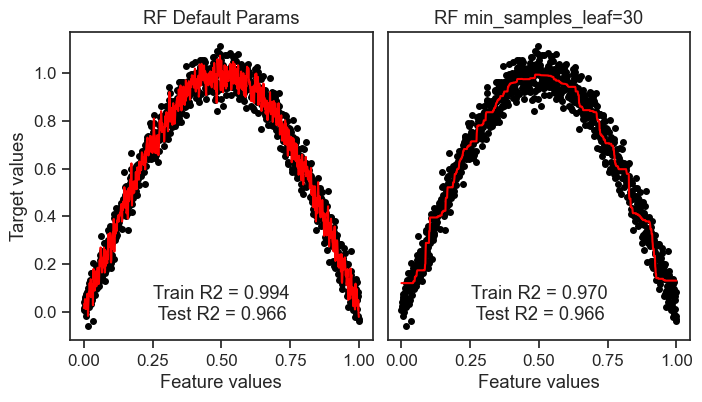

In [12]:
sns.set_theme(style="ticks", font_scale=1.1)
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title('RF Default Params')
plt.plot(x3, y3, 'o', color='black', markersize=4)
plt.plot(x3, y3_pred_default, color='red')

anc = AnchoredText(f'Train R2 = {x3_def_train_score:.3f}\n Test R2 = {x3_def_test_score:.3f}', loc="lower center", frameon=False)
plt.gca().add_artist(anc)
plt.xlabel('Feature values')
plt.ylabel('Target values')

plt.subplot(1, 2, 2)
plt.title('RF min_samples_leaf=30')
plt.plot(x3, y3, 'o', color='black', markersize=4)
plt.plot(x3, y3_pred_minsamplf, color='red')

anc = AnchoredText(f'Train R2 = {x3_set_train_score:.3f}\n Test R2 = {x3_set_test_score:.3f}', loc="lower center", frameon=False)
plt.gca().add_artist(anc)
plt.yticks([])
plt.xlabel('Feature values')

plt.subplots_adjust(wspace=0.05)

### An example where there is zero correlation between feature and target

In [13]:
# Default Parameters
X_tmp = x4.reshape(-1, 1)
rf_reg = RandomForestRegressor(n_estimators=50)
rf_reg.fit(X_tmp, y4)
y4_pred_default = rf_reg.predict(X_tmp)

x4_def_train_score = rf_reg.score(X_tmp, y4)
x4_def_test_score = rf_reg.score(X_tmp, y4_test)
print(f'Train: {x4_def_train_score:.3f} | Test: {x4_def_test_score:.3f}')

max_depth_list, num_nodes, num_leaves = get_max_depth_vals(rf_reg)
print(min(max_depth_list), max(max_depth_list))
print(min(num_nodes), max(num_nodes))
print(min(num_leaves), max(num_leaves))
print()

# Set min_samples_leaf
rf_reg = RandomForestRegressor(n_estimators=50, min_samples_leaf=0.03)
rf_reg.fit(X_tmp, y4)
y4_pred_minsamplf = rf_reg.predict(X_tmp)

x4_set_train_score = rf_reg.score(X_tmp, y4)
x4_set_test_score = rf_reg.score(X_tmp, y4_test)
print(f'Train: {x4_set_train_score:.3f} | Test: {x4_set_test_score:.3f}')

max_depth_list, num_nodes, num_leaves = get_max_depth_vals(rf_reg)
print(min(max_depth_list), max(max_depth_list))
print(min(num_nodes), max(num_nodes))
print(min(num_leaves), max(num_leaves))
print()

Train: 0.794 | Test: -0.479
23 42
1225 1305
613 653

Train: 0.052 | Test: -0.038
5 13
29 35
15 18



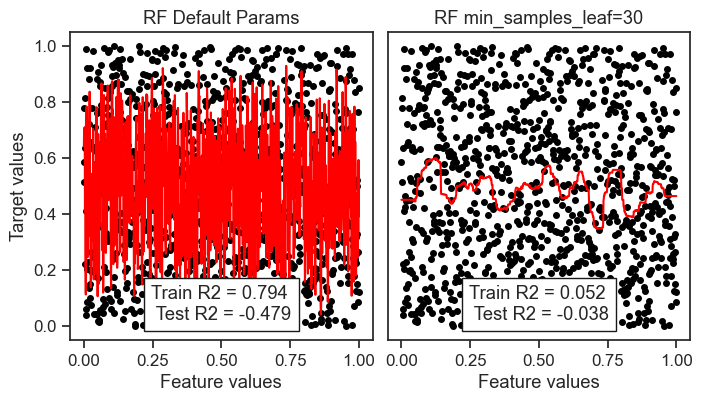

In [14]:
sns.set_theme(style="ticks", font_scale=1.1)
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title('RF Default Params')
plt.plot(x4, y4, 'o', color='black', markersize=4)
plt.plot(x4, y4_pred_default, color='red')

anc = AnchoredText(f'Train R2 = {x4_def_train_score:.3f}\n Test R2 = {x4_def_test_score:.3f}', loc="lower center", frameon=True)
plt.gca().add_artist(anc)
plt.xlabel('Feature values')
plt.ylabel('Target values')

plt.subplot(1, 2, 2)
plt.title('RF min_samples_leaf=30')
plt.plot(x4, y4, 'o', color='black', markersize=4)
plt.plot(x4, y4_pred_minsamplf, color='red')

anc = AnchoredText(f'Train R2 = {x4_set_train_score:.3f}\n Test R2 = {x4_set_test_score:.3f}', loc="lower center", frameon=True)
plt.gca().add_artist(anc)
plt.yticks([])
plt.xlabel('Feature values')

plt.subplots_adjust(wspace=0.05)